In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from numpy import linspace, log1p, expm1
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

In [2]:

df = pd.read_csv('preprocessed_data.csv')
df = df.drop(columns=["date","helipad","house_type","state","city","county"])
newdf = df.copy()
newdf = newdf[newdf['price'] >= 200000] 




<Axes: xlabel='price', ylabel='Count'>

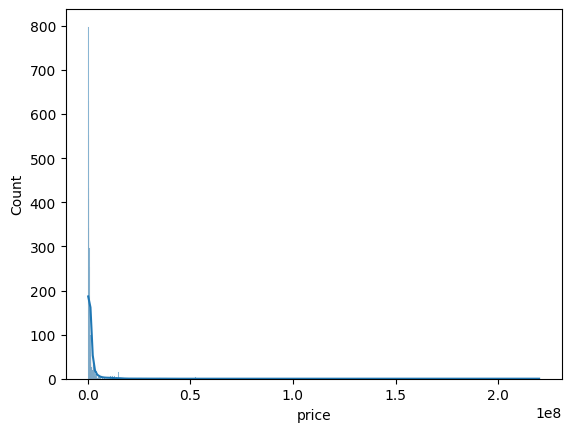

In [3]:
sns.histplot(newdf["price"],kde=True)

In [4]:
newdf['price'] = np.log1p(newdf['price'])


In [5]:
# Feature selection based on data types (excluding object columns)
num_feats = newdf.dtypes[newdf.dtypes != 'object'].index

newdf = newdf.fillna(newdf.mean()) 

# Handling skewed features
skew_feats = newdf[num_feats].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewed_features = skewness[abs(skewness) > 0.75].dropna().index

# Transformation for skewed features 
for feat in skewed_features:
    newdf[feat] = log1p(newdf[feat])  # Log transformation 

x = newdf.drop(columns="price")
y = newdf["price"]

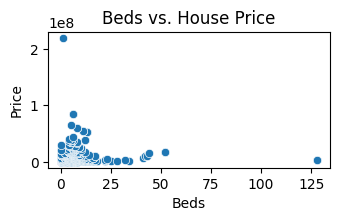

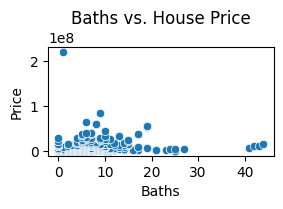

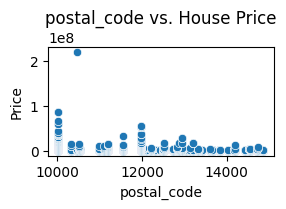

Text(0, 0.5, 'Price')

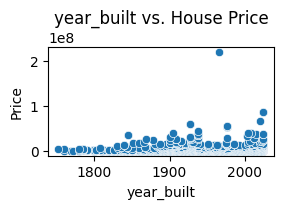

In [6]:
# Scatter plot of features vs. target variable

plt.figure(figsize=(8, 6))
plt.subplot(321)
sns.scatterplot(data=df, x="beds", y="price")
plt.title("Beds vs. House Price")
plt.xlabel("Beds")
plt.ylabel("Price")
plt.show()
plt.subplot(322)
sns.scatterplot(data=df, x="baths", y="price")
plt.title("Baths vs. House Price")
plt.xlabel("Baths")
plt.ylabel("Price")
plt.show()
plt.subplot(323)
sns.scatterplot(data=df, x="postal_code", y="price")
plt.title("postal_code vs. House Price")
plt.xlabel("postal_code")
plt.ylabel("Price")
plt.show()
plt.subplot(324)
sns.scatterplot(data=df, x="year_built", y="price")
plt.title("year_built vs. House Price")
plt.xlabel("year_built")
plt.ylabel("Price")

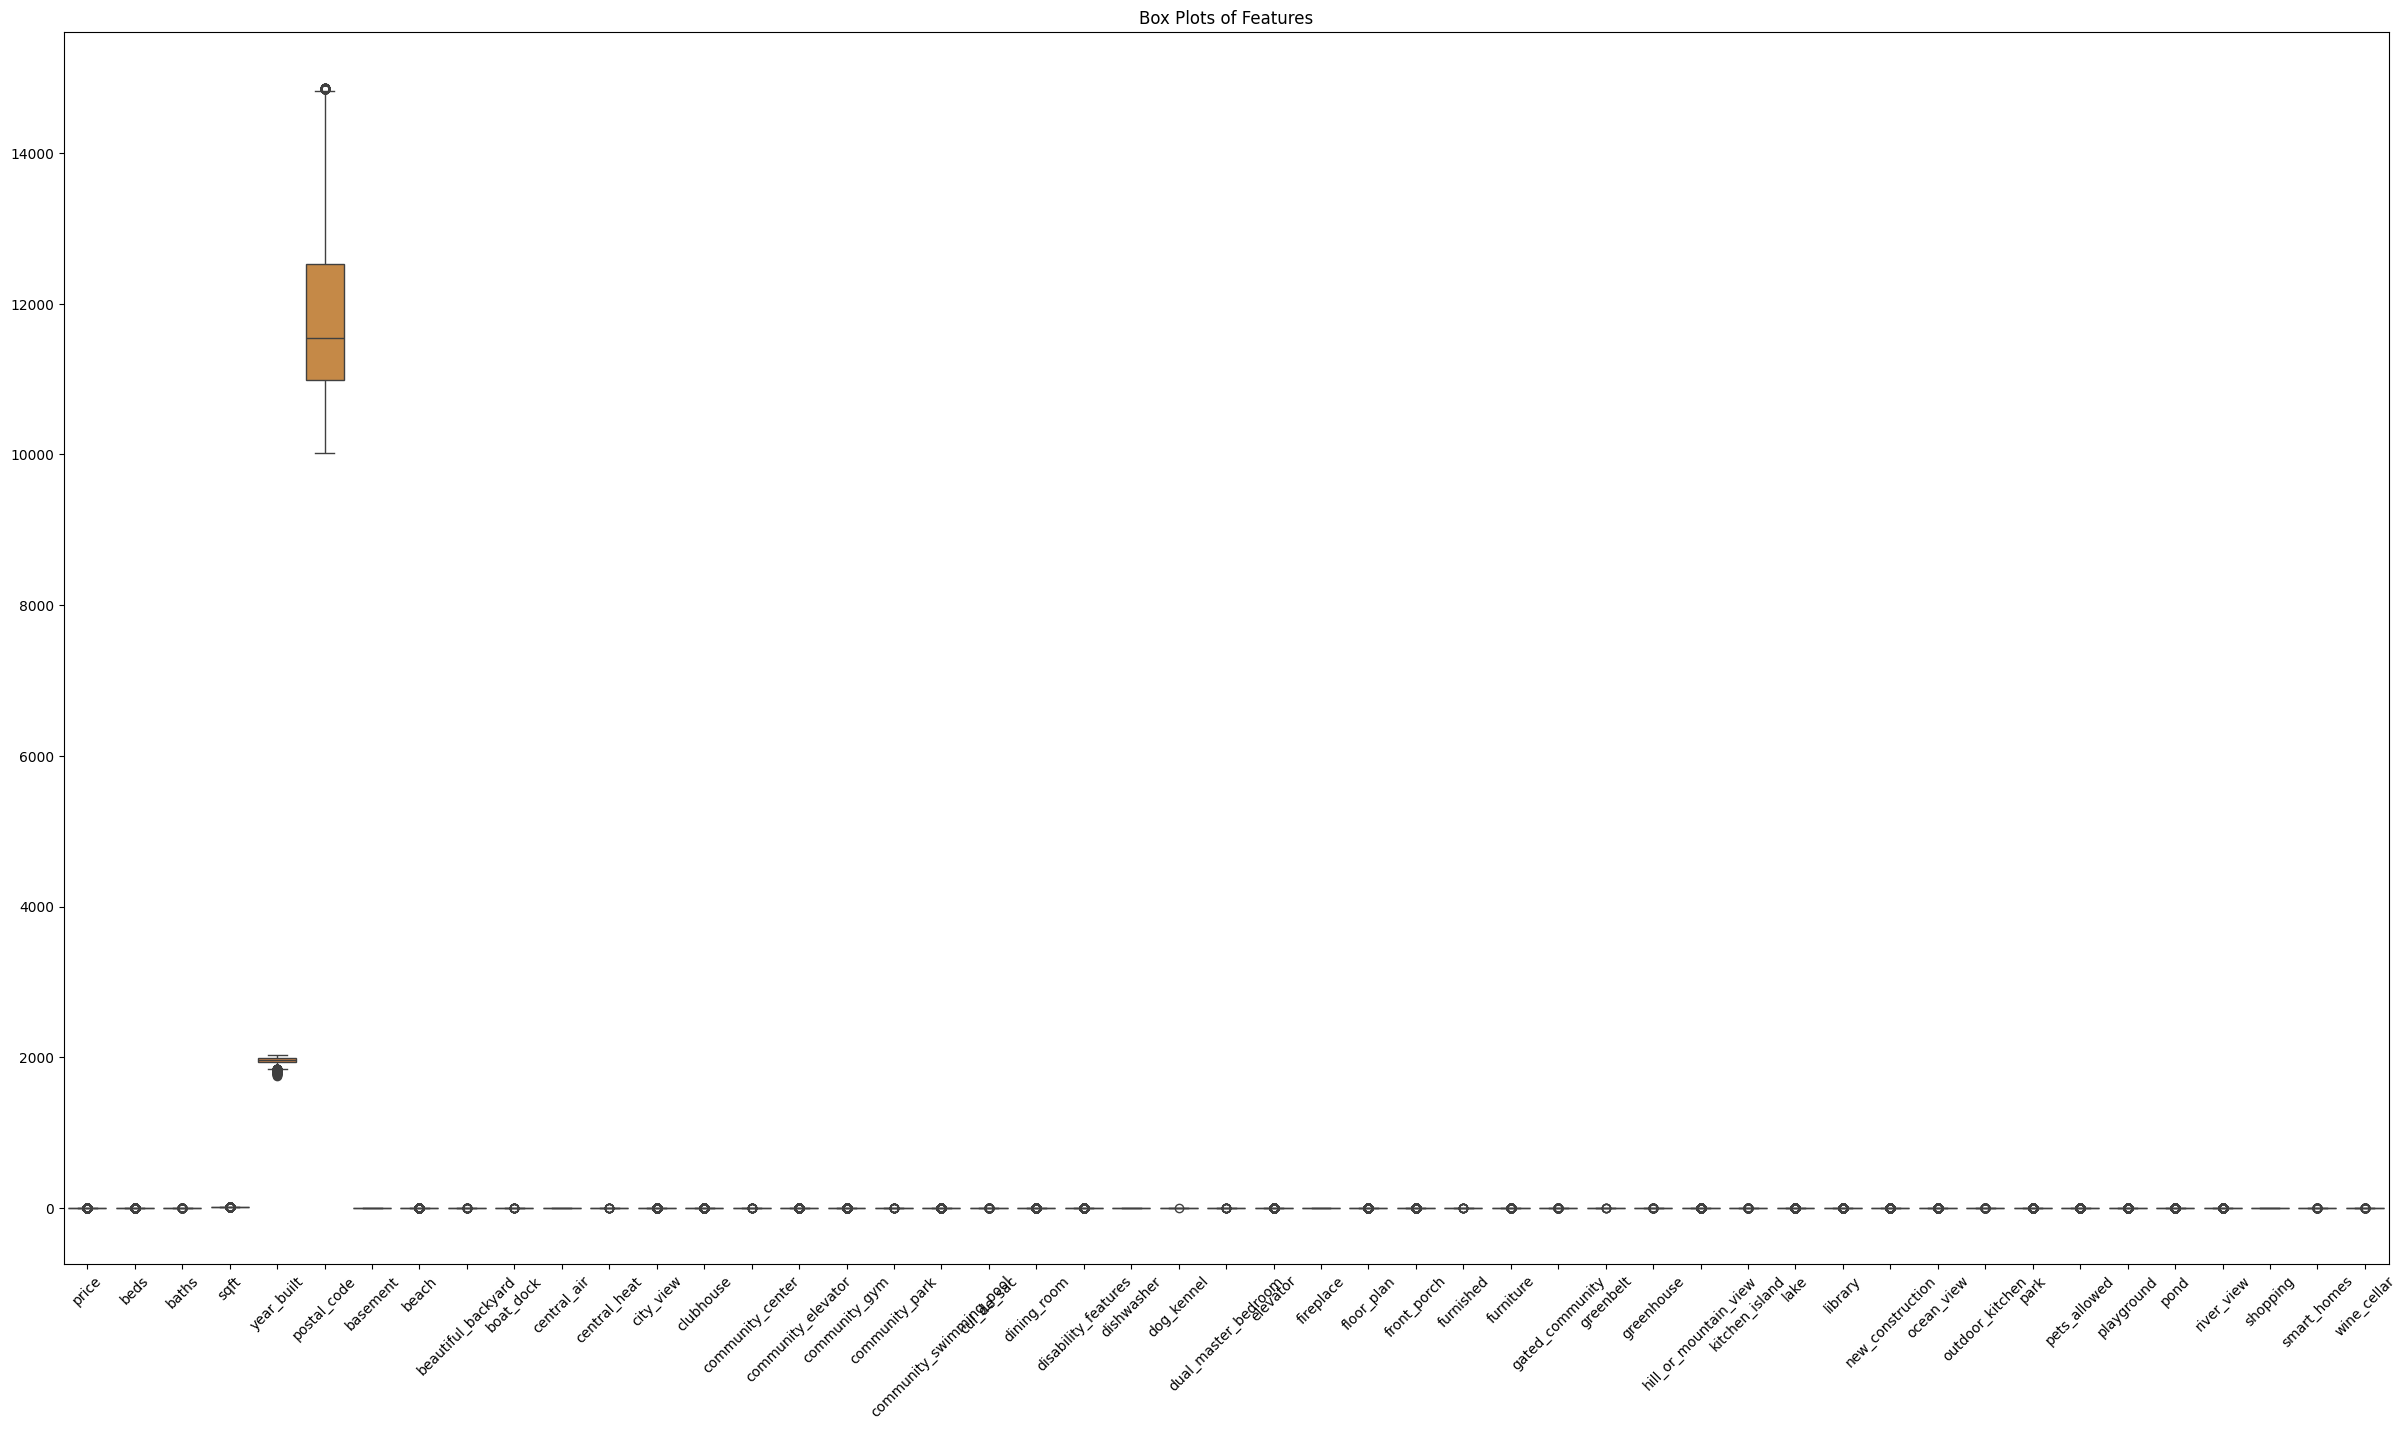

In [7]:
#Box plots of features
plt.figure(figsize=(30, 16))
sns.boxplot(data=newdf)
plt.title("Box Plots of Features")
plt.xticks(rotation=45)
plt.show()

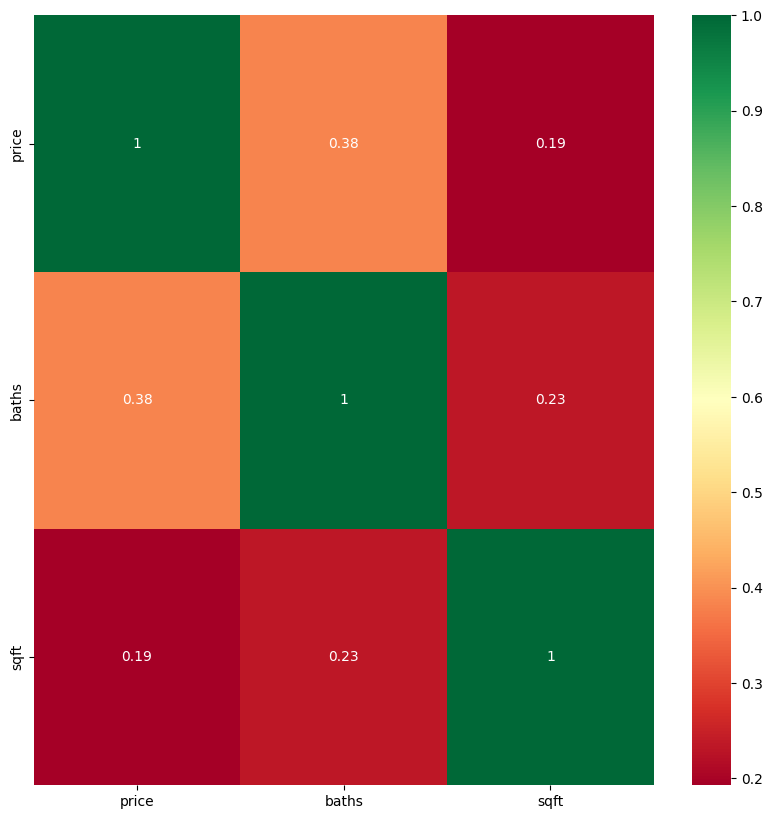

In [8]:
corr = newdf.corr()
highly_corr_features = corr.index[abs(corr["price"])>0.5]
plt.figure(figsize=(10,10))
map = sns.heatmap(df[highly_corr_features].corr(),annot=True,cmap="RdYlGn")

In [9]:
numeric_transformer = SimpleImputer(strategy='median')

numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), x.select_dtypes(include=['number']).columns),
        ('normalizer', MinMaxScaler(), x.select_dtypes(include=['number']).columns)
    ],
    remainder='passthrough'
)

In [10]:

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)


In [11]:

n_estimators = [int(x) for x in linspace(start=200, stop=2000, num=10)]
max_depth = [int(x) for x in linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid_param = {
    'n_estimators': n_estimators,
    'max_features': ['sqrt', 'log2'],
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}




In [12]:
n_estimators=[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid_param = {'n_estimators': n_estimators,
             'max_features': ['sqrt', 'log2'], 
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}

In [13]:
from sklearn.ensemble import RandomForestRegressor
# the model prior to hyperparameter optimization
RFR=RandomForestRegressor(random_state=1)
from sklearn.model_selection import RandomizedSearchCV
RFR_random = RandomizedSearchCV(estimator = RFR, param_distributions = grid_param, n_iter = 1, cv = 5, verbose=2, random_state=42, n_jobs = -1)
RFR_random.fit(x_train, y_train) 
print(RFR_random.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': True}


In [14]:
Best_RFR = RandomForestRegressor(n_estimators=1000, min_samples_split=2, min_samples_leaf=1,max_features='sqrt', max_depth=40, bootstrap=False)

In [15]:
Best_RFR.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=1000)

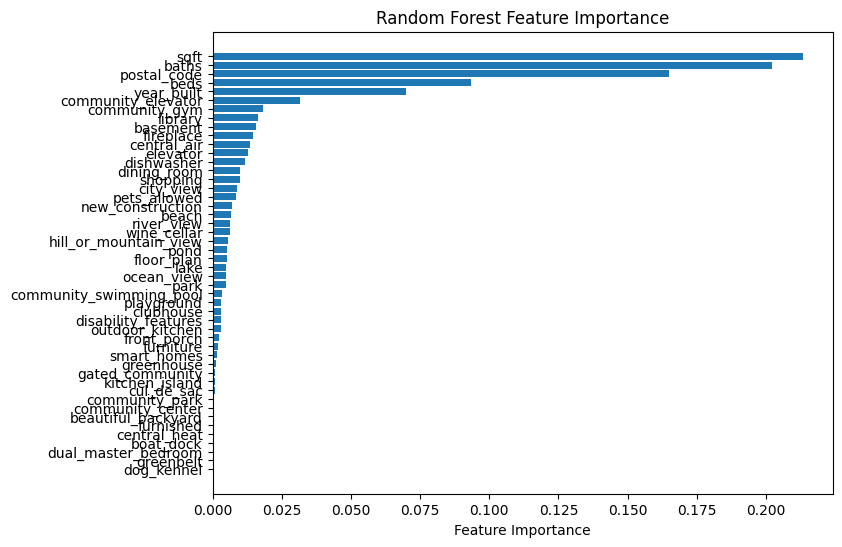

In [16]:
plt.figure(figsize=(8, 6))
feature_importance = Best_RFR.feature_importances_
sorted_idx = feature_importance.argsort()
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), x.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [17]:

from sklearn.model_selection import KFold, cross_val_score
n_folds=5
def rmse_cv(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(x_train)
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv = kf))
    return(rmse.mean())
 
rmse_cv(Best_RFR)

# Prediction on test data
predictions = Best_RFR.predict(x_test)

# Inverse transformation on predictions
predictions = expm1(predictions)  # Anti-log transformation


y_test = expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f"R-squared (R²): {r2:.2f}")

# Evaluation metrics
mean_price = y_test.mean()
print(f"Mean of original target: {mean_price:.2f}")  



Root Mean Squared Error (RMSE): 0.42
R-squared (R²): 0.82
Mean of original target: 13.54


In [18]:
predictions

array([13.68767832, 13.61234148, 15.53380305, ..., 13.26905948,
       14.37172598, 12.38085001])

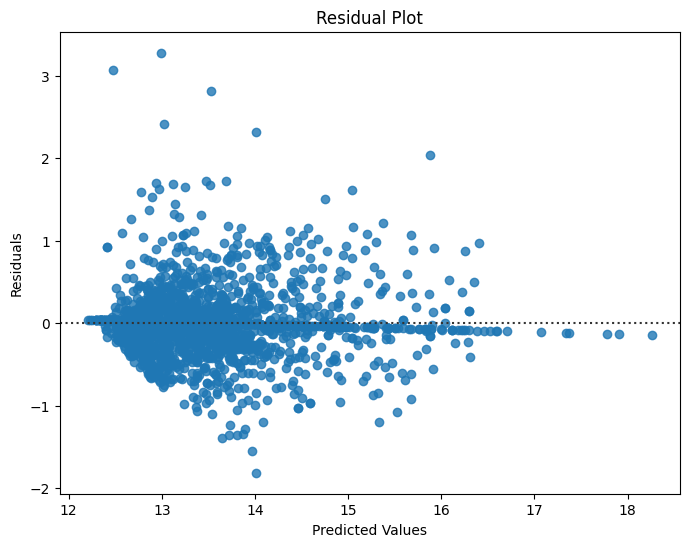

In [19]:
#Residual plots
plt.figure(figsize=(8, 6))
sns.residplot(x=predictions, y=y_test)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

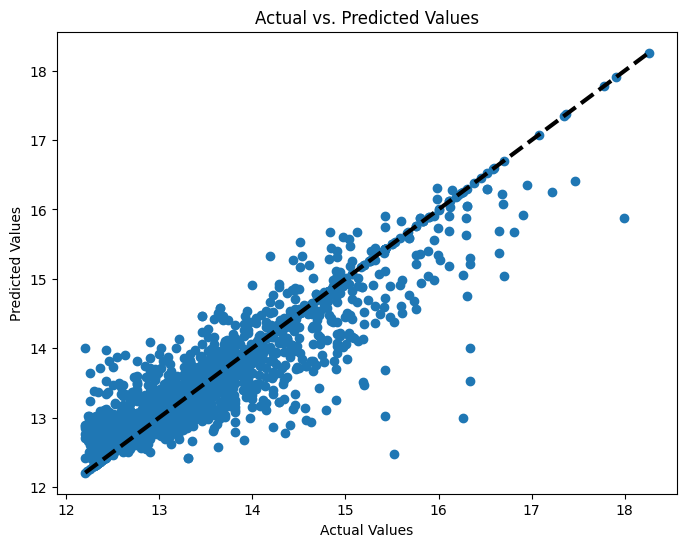

In [20]:
#Actual vs. predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()